### Forecasting do número de chamadas recebidas

O principal objetivo do notebook é a construção de um modelo de forecasting para realização da previsão do número de chamadas recebidas no call center. Dessa forma, o dimensionamento dos operadores será mais eficaz, diminuindo as taxas de improdutividade e consequentemente a quantidade de operadores que deverá ser contratada.

#### 1. Importação das bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from datetime import datetime
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

#### 2. Importação da base

Inicialmente, utilizamos dados somente de 1 mês para compreender melhor como a curva de ligações se comporta ao longo dos dias

In [5]:
df = pd.read_excel('base_pronta_agosto.xlsx')

#### 3. Tratamento dos dados

In [6]:
#verificando se o df possui algum index já
df.index

RangeIndex(start=0, stop=893, step=1)

In [7]:
#indexando a coluna df para utilização no time series
df.set_index('data_hora', inplace=True)

In [8]:
#confirmando o index
df.index

DatetimeIndex(['2021-08-01 08:00:00', '2021-08-01 08:30:00',
               '2021-08-01 09:00:00', '2021-08-01 09:30:00',
               '2021-08-01 10:00:00', '2021-08-01 10:30:00',
               '2021-08-01 11:00:00', '2021-08-01 11:30:00',
               '2021-08-01 12:00:00', '2021-08-01 12:30:00',
               ...
               '2021-08-31 17:30:00', '2021-08-31 18:00:00',
               '2021-08-31 18:30:00', '2021-08-31 19:00:00',
               '2021-08-31 19:30:00', '2021-08-31 20:00:00',
               '2021-08-31 20:30:00', '2021-08-31 21:00:00',
               '2021-08-31 21:30:00', '2021-08-31 22:00:00'],
              dtype='datetime64[ns]', name='data_hora', length=893, freq=None)

In [9]:
#criação da série temporal ts
ts = df['ligacoes_recebidas']

#### 4. Análise exploratória

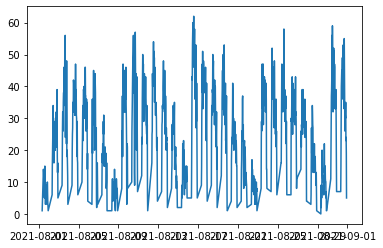

In [10]:
# Visualização da série temporal completa
plt.plot(ts)

Como podemos ver no gráfico acima, existe um pico no início da semana, e esse número vai diminuindo nos finais de semana. Mensalmente, em um primeiro momento, não parece existir sazonalidade. 

Agora, vamos decompor a série para observar melhor como ela se comporta.

In [11]:
# Decomposição da série temporal, criando uma variável para cada formato
decomposicao = seasonal_decompose(ts, period=203, extrapolate_trend='freq')

In [12]:
#separando cada variavel
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

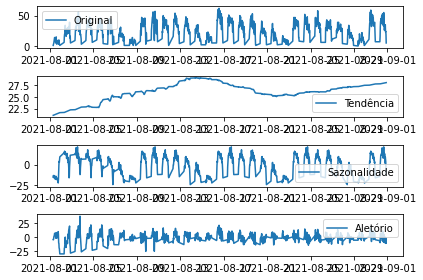

In [13]:
#gráficos para visualização da serie depois da decomposição
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(tendencia, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade (flutuações perí) - ela está assim pq a sazonalidade é diária, então o gráfico fica 'apertado' para mostrar essa flutuação
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(aleatorio, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

Como podemos ver na decomposição acima, a série possui uma leve tendência mensal e sazonalidade diária e semanal. Agora, vamos importar uma base mais completa, de 3 meses para trabalharmos melhor já na modelagem do modelo.

#### 4.1 Análise exploratória da base número 2

In [74]:
forecast.to_excel('previsao_agosto.xlsx')

#### Previsão de junho a agosto

In [3]:
df_trimestre = pd.read_excel('base_pronta.xlsx')

In [4]:
#verificando se o df possui algum index já
df_trimestre.index

RangeIndex(start=0, stop=2671, step=1)

In [5]:
#indexando a coluna df para utilização no time series
df_trimestre.set_index('data_hora', inplace=True)

In [6]:
#verificando o index dos dados
df_trimestre.index

DatetimeIndex(['2021-06-01 08:00:00', '2021-06-01 08:30:00',
               '2021-06-01 09:00:00', '2021-06-01 09:30:00',
               '2021-06-01 10:00:00', '2021-06-01 10:30:00',
               '2021-06-01 11:00:00', '2021-06-01 11:30:00',
               '2021-06-01 12:00:00', '2021-06-01 12:30:00',
               ...
               '2021-08-31 17:30:00', '2021-08-31 18:00:00',
               '2021-08-31 18:30:00', '2021-08-31 19:00:00',
               '2021-08-31 19:30:00', '2021-08-31 20:00:00',
               '2021-08-31 20:30:00', '2021-08-31 21:00:00',
               '2021-08-31 21:30:00', '2021-08-31 22:00:00'],
              dtype='datetime64[ns]', name='data_hora', length=2671, freq=None)

In [7]:
#criação da série temporal ts
ts_trimestre = df_trimestre['ligacoes_recebidas']

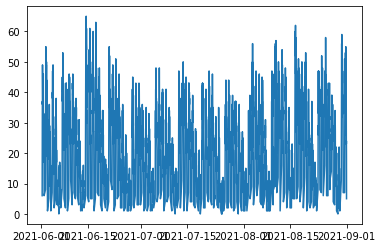

In [8]:
# Visualização da série temporal completa
plt.plot(ts_trimestre)

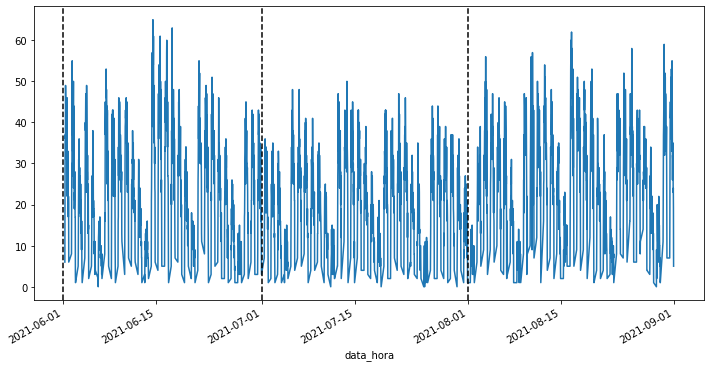

In [8]:
#gráfico plotado com linhas demarcando o início e final de cada mês
ax = ts_trimestre.plot(x='data', y='ligacoes_recebidas', figsize=(12,6))
xcoords = ['2021-06-01', '2021-07-01', '2021-08-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

Como podemos ver no gráfico acima, os dados possuem uma curva mensal, semanal e diária. Dessa forma, precisamos encontrar algum algoritmo que modele bem esses 3 tipos de sazonalidade.

In [9]:
# Decomposição da série temporal, criando uma variável para cada formato
decomposicao = seasonal_decompose(ts_trimestre, period=202, extrapolate_trend='freq')

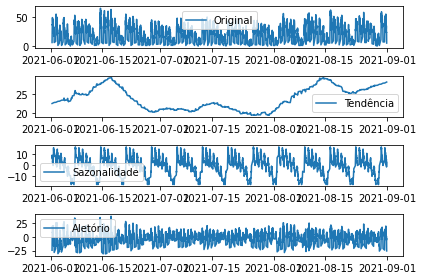

In [10]:
#criação das variáveis separadas
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

plt.subplot(4,1,1)
plt.plot(ts_trimestre, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(tendencia, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade (flutuações perí) - ela está assim pq a sazonalidade é diária, então o gráfico fica 'apertado' para mostrar essa flutuação
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(aleatorio, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

#### 5. Construção do modelo: holt winters - exponential smoothing

In [11]:
#criando variáveis de treino e teste para testar o forecasting
train_trimestre = df_trimestre.ligacoes_recebidas[:1859]
test_trimestre = df_trimestre.ligacoes_recebidas[1859:]

In [12]:
model_tri=ExponentialSmoothing(train_trimestre.values,trend='add', seasonal='add', seasonal_periods=203).fit()

In [13]:
test_pred_trimestre=model_tri.forecast(812)

In [14]:
forecast_trimestre = pd.DataFrame(test_pred_trimestre, index=test_trimestre.index, columns=['ligacoes'])

<AxesSubplot:xlabel='data_hora'>

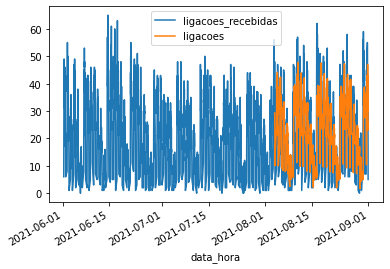

In [15]:
pd.concat([ts_trimestre, forecast_trimestre], axis=1).plot()

#### 6. Avaliação das métricas do modelo

In [17]:
#analisando a eficácia do modelo:
## mape dá infinito pq existem valores 0 no modelo
## rmse é o desvio padrão da série, quanto em média os valores desviam dos originais
## me mostra a média da diferença entre os valores reais e previstos
## mae pega a soma da diferença absoluta do real para a previsão e calcula a média deles

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape': mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

forecast_accuracy(test_pred_trimestre, test_trimestre.values)

{'mape': inf,
 'me': -2.580050065927669,
 'mae': 9.378509683828016,
 'mpe': inf,
 'rmse': 12.607024353012694,
 'corr': 0.5273501557531585}

Os valores de mape e mpe dão infinito pois temos dados com valores igual a 0 na nossa base. Assim, vamos seguir a análise com a métrica principal de avaliação sendo o RMSE.

Para construção do restante dos modelos, modificamos a base pois percebemos um erro na anterior. Dessa forma, utilizamos agora dados de agosto a outubro.

#### 1. Importação da base número 3

In [14]:
df = pd.read_excel('tbats.xlsx')

#### 2. Tratamento e análise exploratória

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   intervalo  1031 non-null   datetime64[ns]
 1   ligacoes   1031 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 16.2 KB


In [16]:
df.set_index('intervalo', inplace=True)

In [17]:
ts=df['ligacoes']

#### 3. Criação do modelo: Holt Winters

In [18]:
#criando variáveis de treino e teste para testar o forecasting
train_hist = df.ligacoes[:516]
test_hist = df.ligacoes[516:]

#restante: 710

In [19]:
train_hist.head()

intervalo
2021-08-29 08:00:00     2
2021-08-29 08:30:00     8
2021-08-29 09:00:00     5
2021-08-29 09:30:00     7
2021-08-29 10:00:00    16
Name: ligacoes, dtype: int64

In [20]:
model_tri=ExponentialSmoothing(train_hist.values, trend='add', seasonal='add', seasonal_periods=206).fit()

In [21]:
test_pred_hist=model_tri.forecast(515)

In [22]:
forecast_trimestre = pd.DataFrame(test_pred_hist, index=test_hist.index, columns=['ligacoes_prev'])

In [23]:
df_novo = pd.concat([ts, forecast_trimestre], axis=1)

<AxesSubplot:xlabel='intervalo'>

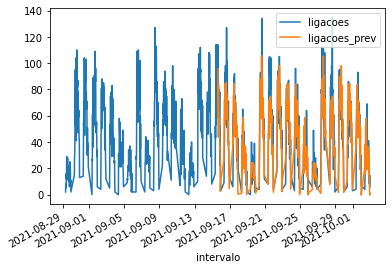

In [24]:
df_novo.plot()

#### 4. Avaliação das métricas de desempenho

In [25]:
#analisando a eficácia do modelo:
## mape dá infinito pq existem valores 0 no modelo
## rmse é o desvio padrão da série, quanto em média os valores desviam dos originais
## me mostra a média da diferença entre os valores reais e previstos
## mae pega a soma da diferença absoluta do real para a previsão e calcula a média deles

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape': mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

forecast_accuracy(test_pred_hist, test_hist.values)

{'mape': inf,
 'me': -2.6670517959664686,
 'mae': 13.216628689279373,
 'mpe': nan,
 'rmse': 17.174842553040946,
 'corr': 0.7947376469044409}

In [45]:
forecast_trimestre.to_excel('forecast_hw.xlsx')

Nesse caso, temos que o RMSE aumentou. Não escolhemos o modelo, pois necessitamos de algo mais genérico. Foi testado outras bases e verificamos que o número de períodos passados como parâmetro na construção influencia fortemente a previsão. Como iremos trabalhar com bases diferentes, esse modelo nao é o ideal para o momento.

#### 5. Construção de modelo: XGBoost

Outro modelo que iremos testar é o XGBoost. Para isso, utilizamos a mesma base, porém com dados desde 2019.

In [27]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [28]:
df = pd.read_excel('teste_prophet.xlsx')

In [29]:
df.head()

,intervalo,ligacoes
0,2019-01-02 08:00:00,13
1,2019-01-02 08:30:00,9
2,2019-01-02 09:00:00,21
3,2019-01-02 09:30:00,44
4,2019-01-02 10:00:00,60


In [30]:
#precisa transformar a base em uma como se fosse de supervised learning
# para isso, separar todas as informaçoes possíveis da data

df['hour'] = df['intervalo'].dt.hour
df['minutes'] = df['intervalo'].dt.minute
df['dayofweek'] = df['intervalo'].dt.dayofweek
df['month'] = df['intervalo'].dt.month
df['year'] = df['intervalo'].dt.year
df['dayofmonth'] = df['intervalo'].dt.day

In [31]:
df.head()

,intervalo,ligacoes,hour,minutes,dayofweek,month,year,dayofmonth
0,2019-01-02 08:00:00,13,8,0,2,1,2019,2
1,2019-01-02 08:30:00,9,8,30,2,1,2019,2
2,2019-01-02 09:00:00,21,9,0,2,1,2019,2
3,2019-01-02 09:30:00,44,9,30,2,1,2019,2
4,2019-01-02 10:00:00,60,10,0,2,1,2019,2


In [32]:
df=df.drop(['intervalo'],axis=1)

In [33]:
#dividir a base em treino e teste. treino até 2020, teste a partir de 2021

df_train=df[df['year']<=2020]
X_train=df_train.drop(['ligacoes'],axis=1)
y_train=df_train['ligacoes']

In [34]:
df_test=df[df['year']>=2021]
X_test=df_test.drop(['ligacoes'],axis=1)
y_test=df_test['ligacoes']

In [35]:
df_train.tail()

,ligacoes,hour,minutes,dayofweek,month,year,dayofmonth
21077,24,16,0,3,12,2020,31
21078,8,16,30,3,12,2020,31
21079,14,17,0,3,12,2020,31
21080,6,17,30,3,12,2020,31
21081,6,18,0,3,12,2020,31


In [36]:
df_test.tail()

,ligacoes,hour,minutes,dayofweek,month,year,dayofmonth
29859,22,8,30,4,10,2021,29
29860,37,9,0,4,10,2021,29
29861,68,9,30,4,10,2021,29
29862,70,10,0,4,10,2021,29
29863,61,10,30,4,10,2021,29


In [291]:
#modelando o regressor
#regressor utiliza a API do scikit-learn
reg = xgb.XGBRegressor(n_estimators=1500, #numero de arvores
    learning_rate=0.2, #taxa de aprendizado das arvores (quanto maior o numero de arvores, menor deve ser o learning rate)
    subsample=0.8, #% dos dados de treino que o modelo vai usar 
    colsample_bytree=1, 
    colsample_bylevel=1,
    colsample_bynode=1,
    max_depth=10, #profundidade das arvores. muitas arvores e arvores muito profundas podem dar overfit fácil
    gamma=0,
    objective = 'reg:squarederror', 
    booster= 'gbtree',
    tree_method='hist')
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100,
        verbose=False)  # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='hist', validate_parameters=1, verbosity=None)

Analisando a importância que o algoritmo dá para cada variável, temos que a principal é a hora, em seguida dia do mês e depois mês. Analisando o modelo de negócios da empresa, os dois primeiros realmente estão certos, já que a quantidade de ligações varia ao longo do dia (hora) e do dia do mês também. Porém, a variável mês não é tão relevante assim. O mais importante seria dayofweek. Isso já nos indica um ponto de atenção com o modelo.

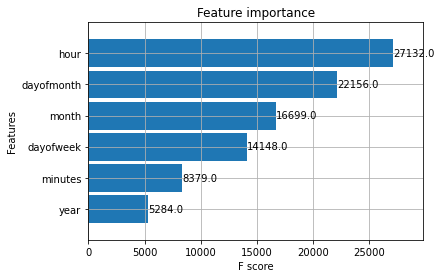

In [292]:
_ = plot_importance(reg, height=0.9)

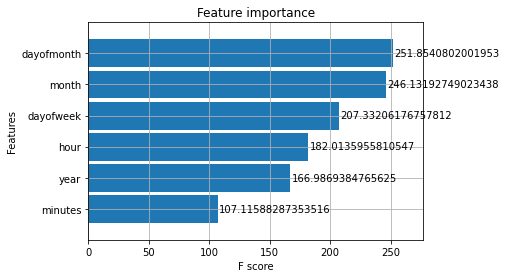

In [293]:
_ = plot_importance(reg, height=0.9, importance_type="cover")

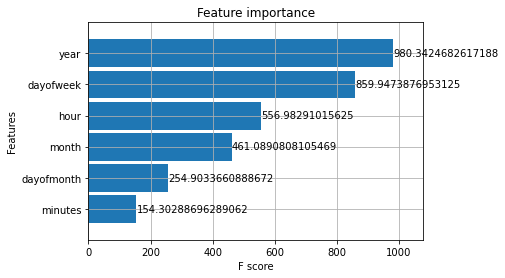

In [294]:
_ = plot_importance(reg, height=0.9, importance_type="gain")

In [295]:
df_test['lig_prev'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

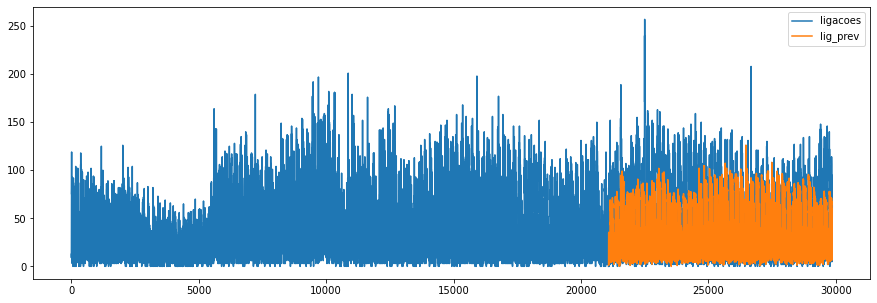

In [296]:
_ = df_all[['ligacoes','lig_prev']].plot(figsize=(15, 5))

In [297]:
pred = reg.predict(X_test)

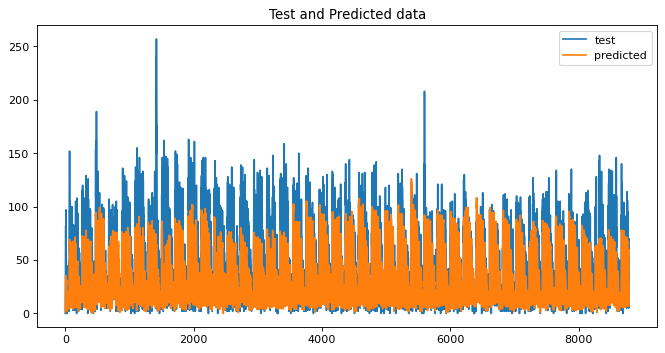

In [298]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(df_test))
plt.plot(x_ax, df_test['ligacoes'], label="test")
plt.plot(x_ax, pred , label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

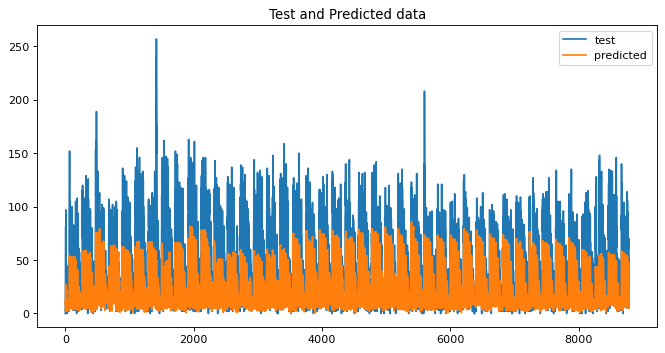

In [114]:
#mais aproximado, somente com os valores de teste. configurações:

'''
reg = xgb.XGBRegressor(n_estimators=1500, #numero de arvores
    learning_rate=0.001, #taxa de aprendizado das arvores (quanto maior o numero de arvores, menor deve ser o learning rate)
    subsample=0.8, #% dos dados de treino que o modelo vai usar 
    colsample_bytree=1, 
    colsample_bylevel=1,
    colsample_bynode=1,
    max_depth=12, #profundidade das arvores. muitas arvores e arvores muito profundas podem dar overfit fácil
    gamma=0,
    objective = 'reg:squarederror', 
    booster= 'gbtree',
    tree_method='hist')
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100,
        verbose=False)  # Change verbose to True if you want to see it train
'''

plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(df_test))
plt.plot(x_ax, df_test['ligacoes'], label="test")
plt.plot(x_ax, pred , label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

Como esperado, o modelo não teve um ajuste tão bom nos dados, sendo incapaz de modelar períodos de pico por exemplo.

In [378]:
df_all.to_excel('output_xgb.xlsx')

In [55]:
df_test['error'] = df_test['ligacoes'] - df_test['lig_prev']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['ligacoes','lig_prev','error','abs_error']]

Verifiquei também os dias que mais ocorriam erros, para ver se o feriado influencia em alguma coisa, porém, não foi observado nenhuma relação.

In [56]:
error_by_day.sort_values('error', ascending=True).head(10)

ligacoes   lig_prev      error  abs_error
year month dayofmonth                                            
2021 9     7           27.758621  57.629543 -29.870924  30.162913
     6     3           40.142857  65.896736 -25.753881  26.650355
     10    12          23.310345  45.300274 -21.989930  22.295454
     8     9           55.551724  76.930618 -21.378895  22.194417
     6     7           59.275862  79.955994 -20.680134  24.340110
     1     20          58.266667  75.292610 -17.025942  20.370935
     6     20          14.107143  30.939133 -16.831990  18.465536
     4     2           30.655172  47.253521 -16.598349  16.657029
     6     24          49.482759  65.421738 -15.938982  18.831405
           27          15.107143  30.834614 -15.727470  16.413381

In [57]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

ligacoes   lig_prev     error  abs_error
year month dayofmonth                                           
2021 8     29          14.300000  14.549531 -0.249531   5.120946
     1     10          14.142857  15.114198 -0.971341   5.262510
     4     4           19.103448  18.816957  0.286492   5.772392
     3     28          25.068966  24.452024  0.616942   5.803713
     9     19          15.862069  15.779532  0.082536   5.947806
     8     22          12.933333  15.160695 -2.227361   6.045241
     5     2           19.178571  23.157963 -3.979391   6.097192
     7     25          16.166667  15.792130  0.374536   6.201721
           4           16.344828  18.388674 -2.043847   6.249400
           24          23.724138  27.514498 -3.790360   6.313925

#### 5.1 Construção do dmatrix

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2021-08-29 08:00:00 to 2021-10-02 22:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ligacoes  1031 non-null   int64
dtypes: int64(1)
memory usage: 16.1 KB


In [38]:
y, X = df.loc[:,'ligacoes'].values, df.loc[:,['hour', 'minutes', 'dayofweek', 'month', 'year', 'dayofmonth']].values
data_dmatrix = xgb.DMatrix(X,label=y)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#random state é usado para indicar que queremos obter o mesmo valor para as diversas vezes que o código rodar

In [400]:
#n_estimators é o numero de boosted trees do modelo. 1000 é o valor padrão
#max_depth = o quão profundo cada árvore é. 7 é o valor padrão
#learning_rate = taxa de aprendizado das árvores. 0.08 é o valor padrao
#verbosity = grau da verbosity. é o mesmo que pensar "me conta tudo que vc está fazendo o tempo todo"
#objective. deixar como reg:squarederror
#booster pode ser gbtree, gblinear ou dart
#tree method pode ser: 
    #exact - XGBoost considers all candidates from data for tree splitting (slow in performance and not scalable)
    #approximated - pode ser approx, hist, gpu_hist (os dois ultimos são melhores para o reg square)
#n_jobs é Number of parallel threads used to run xgboost
#gamma Minimum loss reduction required to make a further partition on a leaf node of the tree
#min child weight = Minimum sum of instance weight(hessian) needed in a child.
#max delta step = estimativa do peso de cada arvore (?) Maximum delta step we allow each tree’s weight estimation to be
#subsample = ratio da instancia de treino
#colsample by tree = ratio of columns for each tree
#colsample by leve = ratio of columns for each level
#colsample by node = ratio of columns for each split
#scale pos weight = Balancing of positive and negative weights


reg_mod = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=1, 
    colsample_bylevel=1,
    colsample_bynode=1,
    max_depth=10,
    gamma=0,
    objective = 'reg:squarederror', 
    booster='gbtree',
    tree_method='hist'
)

reg_mod.fit(X_train, y_train)

'''
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)
'''

"\nXGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,\n             importance_type='gain', interaction_constraints='',\n             learning_rate=0.08, max_delta_step=0, max_depth=7,\n             min_child_weight=1, missing=nan, monotone_constraints='()',\n             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,\n             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,\n             tree_method='exact', validate_parameters=1, verbosity=None)\n"

In [401]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(reg_mod, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.69


In [409]:
reg_mod.fit(X_train,y_train)

predictions = reg_mod.predict(X_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

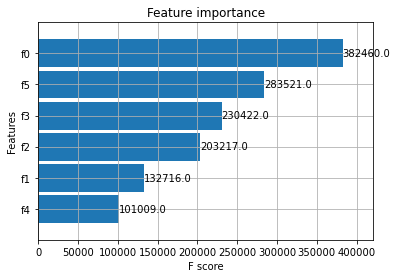

In [403]:
from xgboost import plot_importance
feature_importance = plot_importance(reg_mod, height=0.9)
feature_importance

In [404]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 18.011709


In [405]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.823718


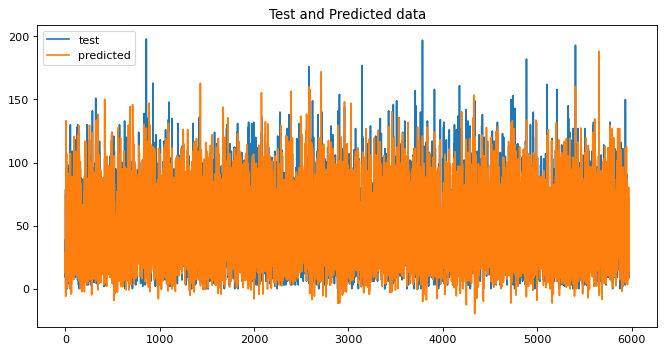

In [408]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, predictions, label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

In [28]:
#padronização 

variaveis = ["minutes", "dayofweek", "month", "year", "dayofyear", "dayofmonth", "weekofyear", 'hour']

In [29]:
z_variaveis = []
for var in variaveis:
    z_variaveis.append("z_" + var)

In [30]:
from sklearn.preprocessing import StandardScaler

X = df[variaveis]
X_std = StandardScaler().fit_transform(X)

In [31]:
X_std

array([[-0.97761454, -0.49248618, -1.57889334, ..., -1.56651342,
        -1.6803777 , -1.61671303],
       [ 1.02289804, -0.49248618, -1.57889334, ..., -1.56651342,
        -1.6803777 , -1.61671303],
       [-0.97761454, -0.49248618, -1.57889334, ..., -1.56651342,
        -1.6803777 , -1.37952385],
       ...,
       [ 1.02289804,  0.50871241,  1.14361739, ...,  1.52019337,
         1.221884  , -1.37952385],
       [-0.97761454,  0.50871241,  1.14361739, ...,  1.52019337,
         1.221884  , -1.14233467],
       [ 1.02289804,  0.50871241,  1.14361739, ...,  1.52019337,
         1.221884  , -1.14233467]])

In [32]:
df = pd.concat([df, pd.DataFrame(X_std, columns=z_variaveis)], axis=1)

In [33]:
df.tail()

,ligacoes,hour,minutes,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,z_minutes,z_dayofweek,z_month,z_year,z_dayofyear,z_dayofmonth,z_weekofyear,z_hour
29859,22,8,30,4,10,2021,302,29,43,1.022898,0.508712,1.143617,1.319307,1.268465,1.520193,1.221884,-1.616713
29860,37,9,0,4,10,2021,302,29,43,-0.977615,0.508712,1.143617,1.319307,1.268465,1.520193,1.221884,-1.379524
29861,68,9,30,4,10,2021,302,29,43,1.022898,0.508712,1.143617,1.319307,1.268465,1.520193,1.221884,-1.379524
29862,70,10,0,4,10,2021,302,29,43,-0.977615,0.508712,1.143617,1.319307,1.268465,1.520193,1.221884,-1.142335
29863,61,10,30,4,10,2021,302,29,43,1.022898,0.508712,1.143617,1.319307,1.268465,1.520193,1.221884,-1.142335


In [34]:
y, X = df.loc[:,'ligacoes'].values, df.loc[:,['z_hour', 'z_minutes', 'z_dayofweek', 'z_month', 'z_year', 'z_dayofyear', 'z_dayofmonth', 'z_weekofyear']].values
data_dmatrix = xgb.DMatrix(X,label=y)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#random state é usado para indicar que queremos obter o mesmo valor para as diversas vezes que o código rodar

In [36]:
reg_mod = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1, 
    colsample_bylevel=0.9,
    colsample_bynode=1,
    max_depth=10,
    gamma=0,
    objective = 'reg:squarederror', 
    booster='gbtree',
    tree_method='hist'
)

reg_mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [37]:
reg_mod.fit(X_train,y_train)

predictions = reg_mod.predict(X_test)

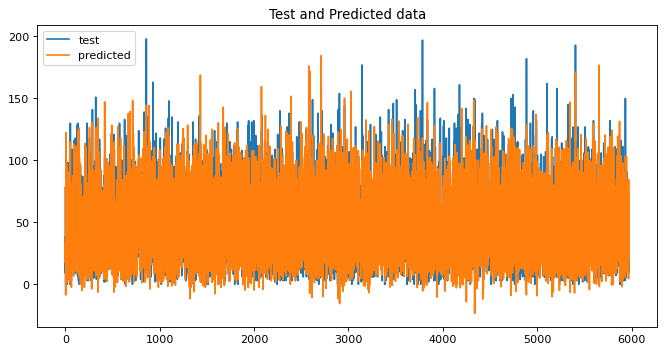

In [38]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, predictions, label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

In [203]:
y = df['ligacoes'].copy()
X = df.drop('ligacoes', axis=1).copy()

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=20)

In [205]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [206]:
params = {'learning_rate': 0.08, 'max_depth': 10}

model = xgb.train(params, dtrain, evals=[(dval, 'eval')], num_boost_round=1500, early_stopping_rounds=50, verbose_eval=False)

In [207]:
y_true = np.array(y_test, dtype=np.float)
y_pred = np.array(model.predict(dtest), dtype=np.float)

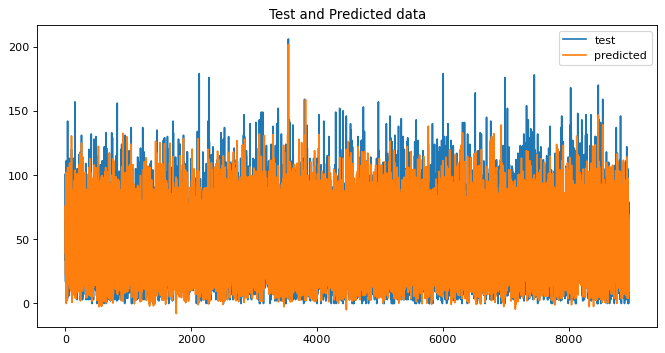

In [208]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_true))
plt.plot(x_ax, y_true, label="test")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

In [211]:
x = pd.DataFrame(y_pred, columns = ['lig_prev'])

In [213]:
x.to_excel('output_xgboost_dm.xlsx')